In [2]:

"""Knowledge Distllation Method"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as Data
import torchvision #torchvision模块包括了一些图像数据集,如MNIST,cifar10等
import matplotlib.pyplot as plt

In [3]:
"""准备数据"""

# 所有的torchvision.datasets数据集的类都是torch.utils.data.Dataset的子类,实现了__getitem__和__len__方法。故可传递给torch.utils.data.DataLoader来加载
# 创建用于Train的数据集,若root目录无数据集,则Download;若root目录有数据集,则从PIL图像数据转换为Tensor
train_data = torchvision.datasets.MNIST(root='./mnist',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data  = torchvision.datasets.MNIST(root='./mnist',train=False,transform=torchvision.transforms.ToTensor())
print("train_data:",train_data.data.size())
print("train_labels:",train_data.targets.size())
print("test_data:",test_data.data.size())

# 根据数据集创建响应的dataLoader
# shuffle（bool, 可选) – 如果每一个epoch内要打乱数据，就设置为True（默认：False）
train_loader = Data.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=500, shuffle=False)
print(len(train_data))
print(len(test_data))


train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])
test_data: torch.Size([10000, 28, 28])
60000
10000


In [10]:
print('\ntrain_loader:\n',train_loader.dataset)
print('\ntrain_data:\n',train_data)
print('\nlen:\n',len(train_data))
print('\nlen:\n',len(test_data))


train_loader:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

train_data:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

len:
 60000

len:
 10000


In [5]:
"""创建模型"""

class CNN(nn.Module):  # 定义了一个类,名字叫CNN
    #注意: 在模型中必须要定义 `forward` 函数，`backward` 函数（用来计算梯度）会被`autograd`自动创建。 可以在 `forward` 函数中使用任何针对 `Tensor` 的操作。
    def __init__(self):  # 每个类都必须有的构造函数，用来初始化该类
        super(CNN, self).__init__() # 先调用父类的构造函数
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # 本函数配置了卷积层和全连接层的维度
        # Conv2d(in_cahnnels, out_channels, kernel_size, stride, padding=0 ,...)
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2) # 卷积层1: 二维卷积层, 1x28x28,16x28x28, 卷积核大小为5x5
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2) # 卷积层2: 二维卷积层, 16x14x14,32x14x14, 卷积核大小为5x5
        # an affine(仿射) operation: y = Wx + b # 全连接层1: 线性层, 输入维度32x7x7,输出维度128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 全连接层2: 线性层, 输入维度128,输出维度10

    def forward(self, x): #定义了forward函数
        # Max pooling over a (2, 2) window 
        conv1_out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 先卷积,再池化
        # If the size is a square you can only specify a single number
        conv2_out = F.max_pool2d(F.relu(self.conv2(conv1_out)), 2)  # 再卷积,再池化
        res = conv2_out.view(conv2_out.size(0), -1)  # 将conv3_out展开成一维(扁平化)
        fc1_out = F.relu(self.fc1(res)) # 全连接1
        out = self.fc2(fc1_out) # 全连接2
        #return out
        return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


cnn = CNN() #新建了一个CNN对象,其实是一系列的函数/方法的集合
cnn = cnn.cuda() #*.cuda()将模型的所有参数和缓存移动到GPU
print(cnn)



def plot_with_labels(lowDWeights, labels):
    plt.cla() #clear当前活动的坐标轴
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1] #把Tensor的第1列和第2列,也就是TSNE之后的前两个特征提取出来,作为X,Y
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9));
        #plt.text(x, y, s, backgroundcolor=c, fontsize=9)
        plt.text(x, y, str(s),color=c,fontdict={'weight': 'bold', 'size': 9}) #在指定位置放置文本
    plt.xlim(X.min(), X.max());
    plt.ylim(Y.min(), Y.max());
    plt.title('Visualize last layer');
    plt.show();
    plt.pause(0.01)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
"""定义损失函数-这里默认是交叉熵函数"""

loss_func = torch.nn.CrossEntropyLoss()

"""初始化:优化器"""

optimizer = optim.Adam(cnn.parameters(), lr=0.01)  #list(cnn.parameters())会给出一个参数列表,记录了所有训练参数(W和b)的数据
#optimizer =optim.Adam([ {'params': cnn.conv1.weight}, {'params': cnn.conv1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv2.weight}, {'params': cnn.conv2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc1.weight}, {'params': cnn.fc1.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.fc2.weight}, {'params': cnn.fc2.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv3.weight}, {'params': cnn.conv3.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv4.weight}, {'params': cnn.conv4.bias, 'lr': 0.002,'weight_decay': 0 },
#                         {'params': cnn.conv5.weight}, {'params': cnn.conv5.bias, 'lr': 0.002,'weight_decay': 0 },], lr=0.001, weight_decay=0.0001)


In [7]:
"""训练"""

def train(epoch):
    print('epoch {}'.format(epoch))
    #直接初始化为0的是标量,tensor调用item()将返回标量值
    train_loss = 0
    train_acc = 0
    #step是enumerate（）函数自带的索引，从0开始
    for step, (batch_x, batch_y) in enumerate(train_loader):
        # 把batch_x和batth_y移动到GPU
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # 正向传播
        out,_ = cnn(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        # torch.max(tensor,dim:int):tensor找到第dim维度(第0维度是数据下标)上的最大值
        # return: 第一个Tensor是该维度的最大值,第二个Tensor是最大值相应的下标
        pred = torch.max(out, 1)[1]
        # 直接对逻辑量进行sum,将返回True的个数
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()
        if step % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, step * len(batch_x), len(train_loader.dataset),100. * step / len(train_loader), loss.item()))

        #反向传播
        optimizer.zero_grad() # 所有参数的梯度清零
        loss.backward() #即反向传播求梯度
        optimizer.step() #调用optimizer进行梯度下降更新参数
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_data)), train_acc / (len(train_data))))

from matplotlib import cm
try:
    from sklearn.manifold import TSNE; HAS_SK = True
except:
    HAS_SK = False; print('Please install sklearn for layer visualization')

In [9]:
print(train_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()


epoch 1


<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293471
Train Epoch: 1 [1000/60000 (2%)]	Loss: 1.593917
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.604780
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.623144
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.459446
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.291535
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.176069
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.236214
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.250958
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.385545
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.251983
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.248236
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.257465
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.061092
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.174874
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.144804
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.150391
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.080331
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.350367
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.164142
Train Epoch: 1 [200

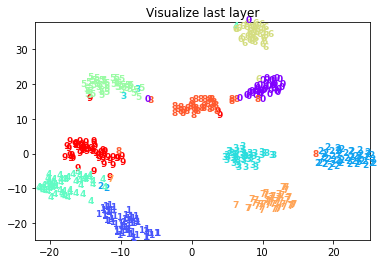

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000210, Accuracy: 9694/10000 (96.94%
epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.040644
Train Epoch: 2 [1000/60000 (2%)]	Loss: 0.246047
Train Epoch: 2 [2000/60000 (3%)]	Loss: 0.063921
Train Epoch: 2 [3000/60000 (5%)]	Loss: 0.104151
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.060650
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.072034
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.133186
Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.149820
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.014158
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.064795
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.069279
Train Epoch: 2 [11000/60000 (18%)]	Loss: 0.079530
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.026253
Train Epoch: 2 [13000/60000 (22%)]	Loss: 0.054639
Train Epoch: 2 [14000/60000 (23%)]	Loss: 0.015968
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.026719
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.142950
Train Epoch: 2 [17000/60000 (28%)]	Loss: 0.046987
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.063836
Train Epoch

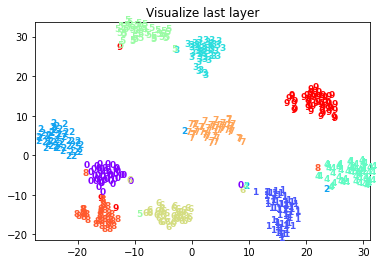

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000227, Accuracy: 9662/10000 (96.62%
epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.035744
Train Epoch: 3 [1000/60000 (2%)]	Loss: 0.043404
Train Epoch: 3 [2000/60000 (3%)]	Loss: 0.046347
Train Epoch: 3 [3000/60000 (5%)]	Loss: 0.076540
Train Epoch: 3 [4000/60000 (7%)]	Loss: 0.004015
Train Epoch: 3 [5000/60000 (8%)]	Loss: 0.008953
Train Epoch: 3 [6000/60000 (10%)]	Loss: 0.112370
Train Epoch: 3 [7000/60000 (12%)]	Loss: 0.012117
Train Epoch: 3 [8000/60000 (13%)]	Loss: 0.034133
Train Epoch: 3 [9000/60000 (15%)]	Loss: 0.034060
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.269936
Train Epoch: 3 [11000/60000 (18%)]	Loss: 0.376518
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.012472
Train Epoch: 3 [13000/60000 (22%)]	Loss: 0.025198
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.004481
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.018558
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.167985
Train Epoch: 3 [17000/60000 (28%)]	Loss: 0.034379
Train Epoch: 3 [18000/60000 (30%)]	Loss: 0.112816
Train Epoch

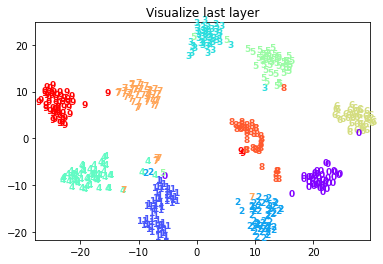

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000181, Accuracy: 9743/10000 (97.43%
epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.070173
Train Epoch: 4 [1000/60000 (2%)]	Loss: 0.095402
Train Epoch: 4 [2000/60000 (3%)]	Loss: 0.017859
Train Epoch: 4 [3000/60000 (5%)]	Loss: 0.066591
Train Epoch: 4 [4000/60000 (7%)]	Loss: 0.034948
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.035645
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.037141
Train Epoch: 4 [7000/60000 (12%)]	Loss: 0.111595
Train Epoch: 4 [8000/60000 (13%)]	Loss: 0.005459
Train Epoch: 4 [9000/60000 (15%)]	Loss: 0.069409
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.112555
Train Epoch: 4 [11000/60000 (18%)]	Loss: 0.074124
Train Epoch: 4 [12000/60000 (20%)]	Loss: 0.059003
Train Epoch: 4 [13000/60000 (22%)]	Loss: 0.246667
Train Epoch: 4 [14000/60000 (23%)]	Loss: 0.133343
Train Epoch: 4 [15000/60000 (25%)]	Loss: 0.011780
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.028943
Train Epoch: 4 [17000/60000 (28%)]	Loss: 0.045405
Train Epoch: 4 [18000/60000 (30%)]	Loss: 0.221328
Train Epoch

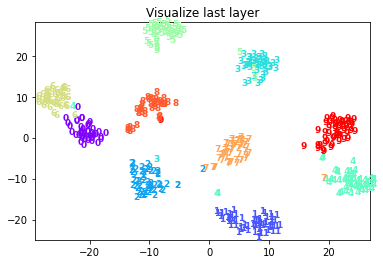

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000194, Accuracy: 9715/10000 (97.15%
epoch 5
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.110115
Train Epoch: 5 [1000/60000 (2%)]	Loss: 0.081591
Train Epoch: 5 [2000/60000 (3%)]	Loss: 0.013103
Train Epoch: 5 [3000/60000 (5%)]	Loss: 0.017844
Train Epoch: 5 [4000/60000 (7%)]	Loss: 0.034405
Train Epoch: 5 [5000/60000 (8%)]	Loss: 0.060843
Train Epoch: 5 [6000/60000 (10%)]	Loss: 0.126850
Train Epoch: 5 [7000/60000 (12%)]	Loss: 0.008057
Train Epoch: 5 [8000/60000 (13%)]	Loss: 0.062097
Train Epoch: 5 [9000/60000 (15%)]	Loss: 0.094064
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.057290
Train Epoch: 5 [11000/60000 (18%)]	Loss: 0.005198
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.020714
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.008251
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.060447
Train Epoch: 5 [15000/60000 (25%)]	Loss: 0.033555
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.014565
Train Epoch: 5 [17000/60000 (28%)]	Loss: 0.108121
Train Epoch: 5 [18000/60000 (30%)]	Loss: 0.113343
Train Epoch

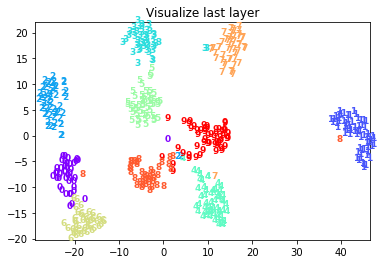

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000294, Accuracy: 9650/10000 (96.50%
epoch 6
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.119476
Train Epoch: 6 [1000/60000 (2%)]	Loss: 0.127874
Train Epoch: 6 [2000/60000 (3%)]	Loss: 0.193671
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.114333
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.201657
Train Epoch: 6 [5000/60000 (8%)]	Loss: 0.088481
Train Epoch: 6 [6000/60000 (10%)]	Loss: 0.058217
Train Epoch: 6 [7000/60000 (12%)]	Loss: 0.007657
Train Epoch: 6 [8000/60000 (13%)]	Loss: 0.059652
Train Epoch: 6 [9000/60000 (15%)]	Loss: 0.199466
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.085181
Train Epoch: 6 [11000/60000 (18%)]	Loss: 0.007745
Train Epoch: 6 [12000/60000 (20%)]	Loss: 0.035835
Train Epoch: 6 [13000/60000 (22%)]	Loss: 0.014620
Train Epoch: 6 [14000/60000 (23%)]	Loss: 0.043682
Train Epoch: 6 [15000/60000 (25%)]	Loss: 0.063344
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.104719
Train Epoch: 6 [17000/60000 (28%)]	Loss: 0.021679
Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.010025
Train Epoch

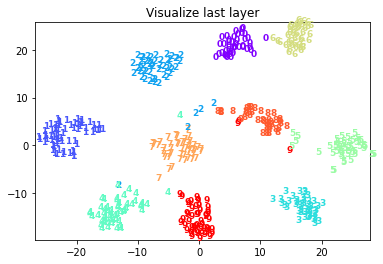

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000155, Accuracy: 9792/10000 (97.92%
epoch 7
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.089144
Train Epoch: 7 [1000/60000 (2%)]	Loss: 0.090993
Train Epoch: 7 [2000/60000 (3%)]	Loss: 0.017731
Train Epoch: 7 [3000/60000 (5%)]	Loss: 0.017033
Train Epoch: 7 [4000/60000 (7%)]	Loss: 0.017843
Train Epoch: 7 [5000/60000 (8%)]	Loss: 0.002714
Train Epoch: 7 [6000/60000 (10%)]	Loss: 0.070360
Train Epoch: 7 [7000/60000 (12%)]	Loss: 0.127305
Train Epoch: 7 [8000/60000 (13%)]	Loss: 0.000370
Train Epoch: 7 [9000/60000 (15%)]	Loss: 0.061964
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.059637
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.037198
Train Epoch: 7 [12000/60000 (20%)]	Loss: 0.076459
Train Epoch: 7 [13000/60000 (22%)]	Loss: 0.045541
Train Epoch: 7 [14000/60000 (23%)]	Loss: 0.203411
Train Epoch: 7 [15000/60000 (25%)]	Loss: 0.041828
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.043798
Train Epoch: 7 [17000/60000 (28%)]	Loss: 0.104908
Train Epoch: 7 [18000/60000 (30%)]	Loss: 0.018095
Train Epoch

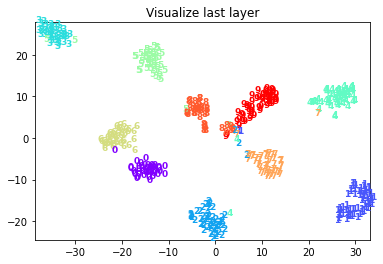

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000203, Accuracy: 9720/10000 (97.20%
epoch 8
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.017891
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.036291
Train Epoch: 8 [2000/60000 (3%)]	Loss: 0.013775
Train Epoch: 8 [3000/60000 (5%)]	Loss: 0.229636
Train Epoch: 8 [4000/60000 (7%)]	Loss: 0.009396
Train Epoch: 8 [5000/60000 (8%)]	Loss: 0.027408
Train Epoch: 8 [6000/60000 (10%)]	Loss: 0.023960
Train Epoch: 8 [7000/60000 (12%)]	Loss: 0.018101
Train Epoch: 8 [8000/60000 (13%)]	Loss: 0.011983
Train Epoch: 8 [9000/60000 (15%)]	Loss: 0.001944
Train Epoch: 8 [10000/60000 (17%)]	Loss: 0.029252
Train Epoch: 8 [11000/60000 (18%)]	Loss: 0.057351
Train Epoch: 8 [12000/60000 (20%)]	Loss: 0.114452
Train Epoch: 8 [13000/60000 (22%)]	Loss: 0.002675
Train Epoch: 8 [14000/60000 (23%)]	Loss: 0.026941
Train Epoch: 8 [15000/60000 (25%)]	Loss: 0.050055
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.016451
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.008632
Train Epoch: 8 [18000/60000 (30%)]	Loss: 0.118263
Train Epoch

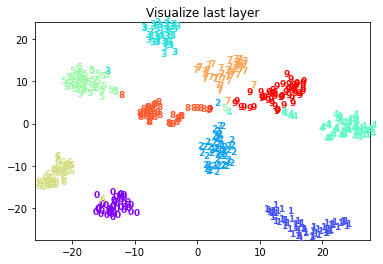

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000173, Accuracy: 9754/10000 (97.54%
epoch 9
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.042231
Train Epoch: 9 [1000/60000 (2%)]	Loss: 0.031326
Train Epoch: 9 [2000/60000 (3%)]	Loss: 0.067010
Train Epoch: 9 [3000/60000 (5%)]	Loss: 0.002840
Train Epoch: 9 [4000/60000 (7%)]	Loss: 0.239871
Train Epoch: 9 [5000/60000 (8%)]	Loss: 0.010247
Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.006622
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.036204
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.007809
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.136216
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.002345
Train Epoch: 9 [11000/60000 (18%)]	Loss: 0.144426
Train Epoch: 9 [12000/60000 (20%)]	Loss: 0.044898
Train Epoch: 9 [13000/60000 (22%)]	Loss: 0.012108
Train Epoch: 9 [14000/60000 (23%)]	Loss: 0.220755
Train Epoch: 9 [15000/60000 (25%)]	Loss: 0.001315
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.012000
Train Epoch: 9 [17000/60000 (28%)]	Loss: 0.082861
Train Epoch: 9 [18000/60000 (30%)]	Loss: 0.033428
Train Epoch

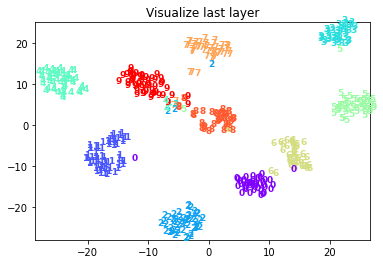

<ipython-input-5-9924f21074c5>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out),fc1_out #返回softmax后的Tensor,以及倒数第二层的Tensor(以进行低维Tensor的可视化)


Test Loss: 0.000185, Accuracy: 9754/10000 (97.54%
epoch 10
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.018678
Train Epoch: 10 [1000/60000 (2%)]	Loss: 0.108972
Train Epoch: 10 [2000/60000 (3%)]	Loss: 0.055706
Train Epoch: 10 [3000/60000 (5%)]	Loss: 0.001643
Train Epoch: 10 [4000/60000 (7%)]	Loss: 0.002253
Train Epoch: 10 [5000/60000 (8%)]	Loss: 0.003093
Train Epoch: 10 [6000/60000 (10%)]	Loss: 0.025364
Train Epoch: 10 [7000/60000 (12%)]	Loss: 0.022913
Train Epoch: 10 [8000/60000 (13%)]	Loss: 0.007964
Train Epoch: 10 [9000/60000 (15%)]	Loss: 0.000707
Train Epoch: 10 [10000/60000 (17%)]	Loss: 0.006951
Train Epoch: 10 [11000/60000 (18%)]	Loss: 0.080183
Train Epoch: 10 [12000/60000 (20%)]	Loss: 0.008487
Train Epoch: 10 [13000/60000 (22%)]	Loss: 0.002338
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.035862
Train Epoch: 10 [15000/60000 (25%)]	Loss: 0.061244
Train Epoch: 10 [16000/60000 (27%)]	Loss: 0.043142
Train Epoch: 10 [17000/60000 (28%)]	Loss: 0.280769
Train Epoch: 10 [18000/60000 (30%)]	Loss: 

KeyboardInterrupt: 

In [8]:
"""准确率"""

def test():
    cnn.eval()
    eval_loss = 0
    eval_acc = 0
    # 打开imshow()交互模式:更新图像后直接执行以后的代码,不阻塞在plt.show()
    plt.ion()
    #无需反向传播计算梯度,不需要进行求导运算
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(test_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            out,last_layer = cnn(batch_x)
            loss = loss_func(out, batch_y)
            #loss =  += F.nll_loss(out, batch_y, size_average=False).item()
            eval_loss += loss.item()
            pred = torch.max(out, 1)[1]
            num_correct = (pred == batch_y).sum()
            eval_acc += num_correct.item()
            #若需绘图,将下面代码块注释去掉
            if step % 100 == 0:
                #t-SNE 是一种非线性降维算法，非常适用于高维数据降维到2维或者3维，进行可视化
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                #最多只画500个点
                plot_only = 500
                #fit_transform函数把last_layer的Tensor降低至2个特征量,即3个维度(2个维度的坐标系)
                low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
                labels = batch_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
            #若需绘图,将上面代码块注释去掉 
    print('Test Loss: {:.6f}, Accuracy: {}/{} ({:.2f}%'.format(eval_loss / (len(test_data)),eval_acc, len(test_data) ,100.*eval_acc / (len(test_data))))
    plt.ioff()

for epoch in range(1, 21):
    train(epoch)
    test()

In [ ]:
print(train_loader.dataset)